In [2]:
import mesa
import networkx as nx
import numpy as np, pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.metrics import pairwise_distances


In [440]:
class ARMAgent(mesa.Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        loc = np.clip(self.model.random.multivariate_normal(self.model.mean, self.model.cov, 1), -1, 1)
        self.identity, self.opinion = np.array([loc[0][0]]), np.array([loc[0][1]])
        
    def step(self):
        other_agent = self.model.schedule.agents[self.random.choice(np.delete(np.arange(self.model.num_agents), self.unique_id))]
        delta_identity = self.identity * other_agent.identity
        #delta_opinion = np.sqrt(sum([(other_agent.opinion[k] - self.opinion[k])**2 / \
        #                       self.model.E[k]**2 for k in range(self.model.B)]))
        #delta_identity = np.sqrt(sum([(other_agent.identity[k] - self.identity[k])**2 / \
        #                       self.model.E[k]**2 for k in range(self.model.I)]))
        #delta = self.model.alpha * delta_identity + (1 - self.model.alpha) * delta_opinion                        
        if self.random.random() <= np.power(0.5, 1):
          dist = self.model.alpha * np.linalg.norm(self.identity - other_agent.identity) + (1 - self.model.alpha) * np.linalg.norm(self.opinion - other_agent.opinion)
          if dist <= self.model.T:
            self.opinion = self.opinion + self.model.R * (other_agent.opinion - self.opinion) 
            #self.identity = self.identity + self.model.Ridentity * (other_agent.identity - self.identity)
          else:
            self.opinion = self.opinion -  self.model.R * (other_agent.opinion - self.opinion)
            #self.identity = self.identity - self.model.Ridentity * (other_agent.identity - self.identity)
          self.opinion = np.clip(self.opinion, -1, 1)
          self.identity = np.clip(self.identity, -1, 1)
        else:
          pass


       

In [52]:
def compute_variance_opinion(model):
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    return sum(np.var(agent_opinions, axis=0))

def compute_variance_identity(model):
    agent_opinions = [agent.identity for agent in model.schedule.agents]
    return sum(np.var(agent_opinions, axis=0))

In [53]:
def compute_agent_affect(agent):
    distances = {group : [] for group in range(agent.model.num_groups)}
    for other_agent in agent.model.schedule.agents:
      if agent.unique_id != other_agent.unique_id:
        distances[other_agent.group].append( 1 if (np.linalg.norm(agent.opinion - other_agent.opinion) <= agent.model.T) else 0)
    tolerance = [np.mean(distances[group]) for group in range(agent.model.num_groups)]
    return np.array(tolerance)
    

In [273]:
class ARMModel(mesa.Model):

    def __init__(self, N, I=1, B=1, G=2, T=.25, E=[0.1], R=.25, Ridentity=.05, alpha=.5,
                 #mu=np.array([.3,.5,.7]), 
                 #sigma=np.array([.2,.2,.2]),
                 seed=None):
        self.num_agents = N
        self.num_groups = G
        self.I = I
        self.B = B
        self.T = T
        self.E = E
        self.R = R
        self.Ridentity = Ridentity
        self.alpha = alpha
        self.mean = np.array([0,0]) 
        self.cov = np.array(
                            [[.2, .1],
                             [.1, .2]])
        #self.grid = mesa.space.NetworkGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.random = np.random.default_rng(seed)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = ARMAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            #x = self.random.randrange(self.grid.width)
            #y = self.random.randrange(self.grid.height)
            #self.grid.place_agent(a, (x, y))
        
        self.datacollector = mesa.DataCollector(
            model_reporters={"variance_opinion": compute_variance_opinion, "variance_identity": compute_variance_identity} , #"affect": compute_affect}, 
            agent_reporters={"opinion": "opinion", "identity": "identity" } # "affect": compute_agent_affect}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [441]:
n_iters = 1
params = {"G": 2, #"mu":np.array([.4, .6]) , "sigma": np.array([.2, .2]),
          "T": .3, "N": 200,
          "alpha": [.6, .7, .8],"seed": 123}

results = mesa.batch_run(
    ARMModel,
    parameters=params,
    iterations=n_iters,
    max_steps=500,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

results_df = pd.DataFrame(results)

100%|██████████| 3/3 [00:06<00:00,  2.17s/it]


In [444]:
results_df["group"] = results_df.identity.apply(lambda x: x[0] <= 0)

In [382]:
runid = 2

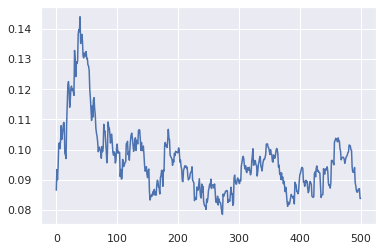

In [ ]:
results2 = results_df[(results_df.RunId == runid) & (results_df.group == 0)]
plt.plot(results2.groupby("Step").affect_diff_02.agg("mean"));

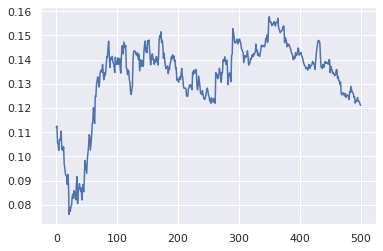

In [ ]:
results0 = results_df[(results_df.RunId == runid) & (results_df.group == 1)]
plt.plot(results0.groupby("Step").affect_diff_20.agg("mean"));

In [442]:
runid = 0

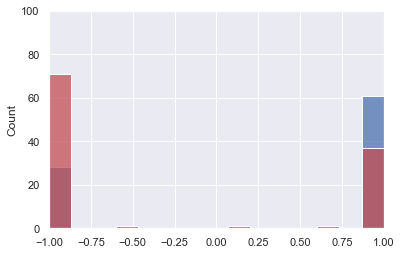

In [445]:
step = 500
results10 = results_df[(results_df.RunId == runid) & (results_df.Step == step) & (results_df.group == 0)] 
results11 = results_df[(results_df.RunId == runid) & (results_df.Step == step) & (results_df.group == 1)]
sns.histplot([ float(value) for value in results10.opinion.values], color="b", bins = 15) 
sns.histplot([ float(value) for value in results11.opinion.values], color="r", bins = 15)
plt.axis([-1, 1, 0, 100]);
#sns.histplot([ float(value) for value in results12.opinion.values], color="g", bins = 15); 

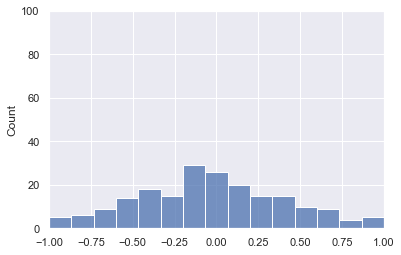

In [446]:
step = 500
results10 = results_df[(results_df.RunId == runid) & (results_df.Step == step) ] 
results11 = results_df[(results_df.RunId == runid) & (results_df.Step == step) ]
sns.histplot([ float(value) for value in results10.identity.values], color="b", bins = 15) 
#sns.histplot([ float(value) for value in results11.opinion.values], color="r", bins = 15)
plt.axis([-1, 1, 0, 100]);

In [447]:
step = 500
results10 = results_df[(results_df.RunId == runid) & (results_df.Step == step) ] 
np.corrcoef([ float(value) for value in results10.identity.values], [ float(value) for value in results10.opinion.values])

array([[1.        , 0.38857393],
       [0.38857393, 1.        ]])

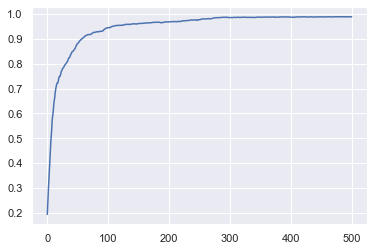

In [448]:
plt.plot(results_df[(results_df.RunId == runid) & (results_df.AgentID == 1) ].variance_opinion.values);

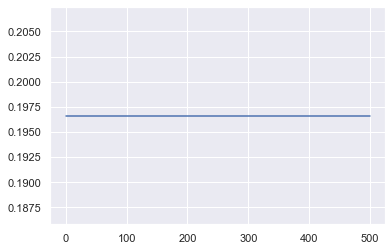

In [449]:
plt.plot(results_df[(results_df.RunId == runid) & (results_df.AgentID == 1) ].variance_identity.values);